In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import ffmpeg
import whisper
import torch
from torch.distributions import Categorical
import numpy as np
from whisper.tokenizer import get_tokenizer
from whisper import audio

In [46]:
# fn = "/tmp/perkins.avi [uS78f4WUbXs].webm" # https://www.youtube.com/watch?v=uS78f4WUbXs
fn = "/tmp/Phasmophobia： No Evidence [QoDTqAwskPU].opus" # https://www.youtube.com/watch?v=QoDTqAwskPU
data, _ = ffmpeg.input(fn).output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='16k').run(quiet=True, input='')
data = np.frombuffer(data, np.int16).astype(np.float32) / 32768.0
model = whisper.load_model("base")
tokenizer = get_tokenizer(model.is_multilingual, language='en')

In [47]:
@torch.no_grad()
def transcribe(model, data, **kwargs):
    language = kwargs['language']
    tokenizer = get_tokenizer(model.is_multilingual, language=kwargs['language'] if 'language' in kwargs else 'en')
    batches, beams = 2, 1
    overlap = 15
    left = 30 - overlap
    for i in range(0, data.shape[0], left * 16000 * batches):
        x = data[i:i+left * 16000 * batches + overlap * 16000]
        mel = audio.log_mel_spectrogram(x)
        mels = []
        for k in range(batches):
            chunk = mel[:, k * left*100: k * left*100 + 3000]
            if chunk.shape[-1] == 0: break
            if chunk.shape[-1] < 3000: chunk = audio.pad_or_trim(chunk, audio.N_FRAMES)
            mels.append(chunk.unsqueeze(0))
        mels = torch.concat(mels, dim=0)

        initial = [*tokenizer.sot_sequence]
        tokens = torch.tensor(initial).repeat(mels.shape[0]*beams, 1)
        audio_features = model.encoder(mels).repeat_interleave(beams, dim=0)
        print(tokens.shape)
        next_tokens = tokens
        logitsc = torch.tensor([])
        kv_cache, hooks = model.install_kv_cache_hooks()
        while not (tokens[:, -1] == tokenizer.eot).all() and tokens.shape[-1] < 120: # Ram Issues
            logits = model.decoder(next_tokens, audio_features, kv_cache=kv_cache)[:, -1:, ]
            logitsc = torch.concat([logitsc, logits[:, :, :tokenizer.timestamp_begin-1].detach()], dim=-2)
            logits[:, :, tokenizer.timestamp_begin+1: tokenizer.timestamp_begin + int(28 // 0.02)] = -np.inf
            # next_tokens = Categorical(logits=logits/0.2).sample()
            next_tokens = logits.argmax(-1)
            next_tokens[tokens[:, -1] == tokenizer.eot] = tokenizer.eot
            tokens = torch.concat([tokens, next_tokens], dim=-1)
        for t in tokens.tolist():
            print(tokenizer.decode_with_timestamps(t))
        print(tokens.shape, logitsc.shape)
        for h in hooks: h.remove()
        kv_cache.clear()
        if (i//(left * 16000 * batches)) >= 2: # HACK for testing
            s = [batches-1, tokens.shape[-1]-len(initial), tokens.shape[-1]-len(initial), tokenizer.timestamp_begin-1]
            logitsc, logitscs = logitsc[:-1].unsqueeze(-2).expand(*s), logitsc[1:].unsqueeze(-3).expand(*s)
            sm = (logitsc.softmax(-1) * logitscs.log_softmax(-1)).sum(-1)
            return tokens.detach(), sm.detach()

torch.Size([2, 3])
<|startoftranscript|><|en|><|transcribe|><|0.00|> Boy do I love light switches love turning them on and off so much fun. I love turning on lights next to my large collection of throwable objects and also empty notebooks. It was sure would suck if someone named Carol Thomas showed up to ruin all my fun Carol Thomas Carol Thomas Carol Thomas. Hey, I've been here for like half an hour. Can we please just call this a shade and go home? We need at least one piece of evidence. I do we though I feel like the evidence is pretty conclusive. Let's go through the checklist. I've already
<|startoftranscript|><|en|><|transcribe|><|0.00|> Carol Thomas, Carol Thomas, Carol Thomas. Hey, I've been here for like half an hour. Can we please just call this a shade and go home? We need at least one piece of evidence. I feel we though, I feel like the evidence is pretty conclusive. Let's go through the checklist. I've already done the checklist. Ghost riding. No, nothing. Temperatures. I 

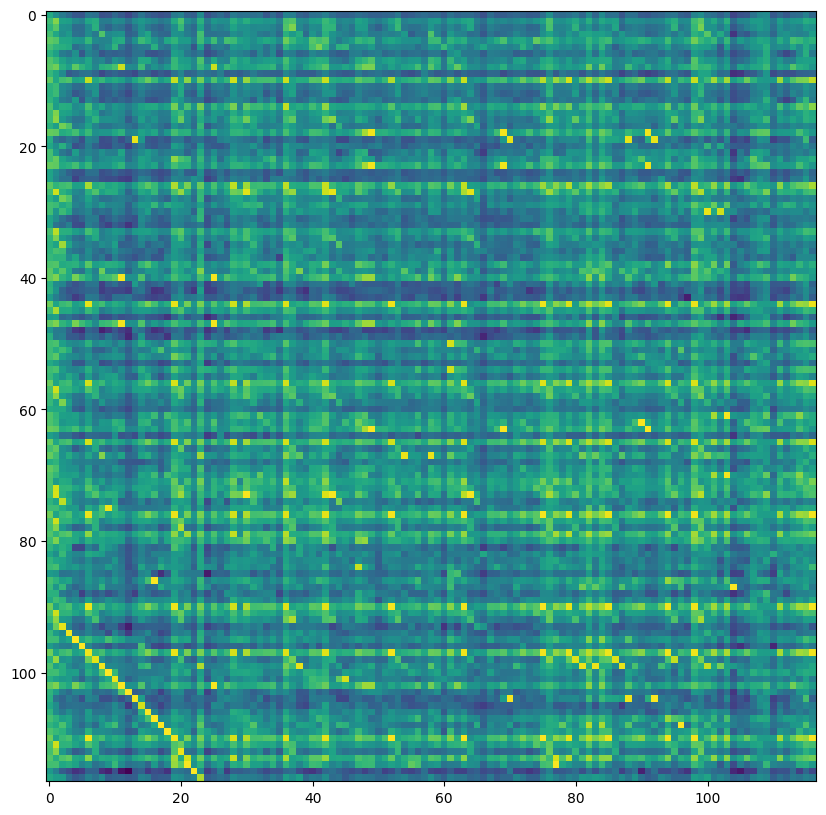

In [48]:
import gc
gc.collect()
tokens, sm = transcribe(model, data, language='en')
tokens = tokens.tolist()
eot0 = len(tokens[0]) if tokenizer.eot not in tokens[0] else tokens[0].index(tokenizer.eot)
eot1 = len(tokens[1]) if tokenizer.eot not in tokens[1] else tokens[1].index(tokenizer.eot)

# Will this work for batches > 2? probably not
sm = sm[:, :eot0, :eot1]
print(tokens[0][len(tokenizer.sot_sequence):])
print(tokens[1][len(tokenizer.sot_sequence):])
plt.figure(figsize=(10, 10))
plt.imshow(sm.detach().numpy()[-1])

-19.35618212725967 21.0 110 19


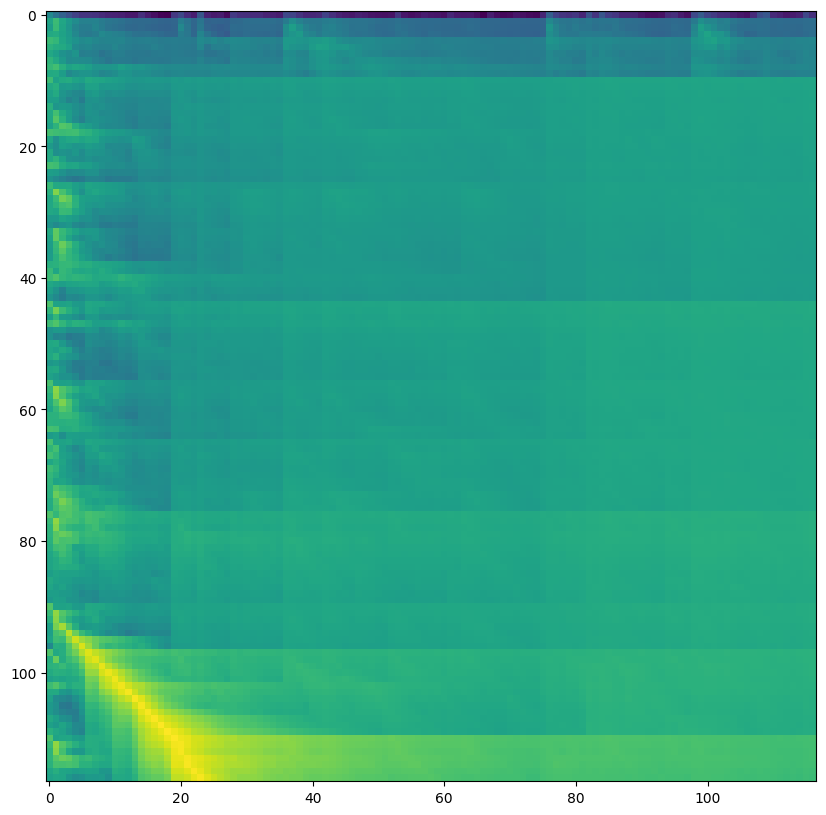

In [49]:
memo = {}
fm, fl, fmi, fmj = -np.inf, 1, 0, 0
for i in range(sm.shape[-2]):
    for j in range(sm.shape[-1]):
        z = [memo.get(d, (0, 0)) for d in [(i-1, j), (i, j-1), (i-1, j-1)]]
        scores, lens = np.array(list(zip(*z)))
        ns = scores + sm[0, i, j].numpy()
        f = (ns/(lens+1)).argmax()
        memo[i, j] = (ns[f], lens[f]+1)
        if (memo[i, j][0]/memo[i, j][1]) > (fm/fl): fm, fl, fmi, fmj = memo[i, j][0], memo[i, j][1], i, j
            
print(fm, fl, fmi, fmj)
scores = [[0 for j in range(sm.shape[-1])] for i in range(sm.shape[-2])]
for i in range(sm.shape[-2]):
    for j in range(sm.shape[-1]):
        scores[i][j] = memo[i, j][0]/memo[i, j][1]
plt.figure(figsize=(10, 10))
plt.imshow(scores)

In [50]:
dirs = [(-1, 0), (0, -1), (-1, -1)]
ci, cj = fmi, fmj
l = memo[ci, cj][1]
trace = []
z = [i for i in range(len(dirs))]
while l > 1:
    trace.append((ci, cj))
    d = sorted(z, key=lambda x: memo.get((ci+dirs[x][0], cj+dirs[x][1]), (-np.inf,))[0])[-1] # argmax
    di, dj = dirs[d]
    ci, cj = ci+di, cj+dj
    l -= 1
print(trace)

[(110, 19), (109, 18), (108, 17), (107, 16), (106, 15), (105, 14), (104, 13), (103, 12), (102, 11), (101, 10), (100, 9), (99, 8), (98, 7), (97, 6), (96, 5), (95, 4), (94, 3), (93, 2), (92, 1), (91, 1)]


In [51]:
f, s = np.array(list(zip(*trace)))[..., ::-1] + len(tokenizer.sot_sequence)
print(f)
print(s)
print(tokenizer.decode(np.array(tokens[0])[np.array(f)].tolist()))
print(tokenizer.decode(np.array(tokens[1])[np.array(s)].tolist()))
# f = tokens[0][len(tokenizer.sot_sequence):]
# s = tokens[1][len(tokenizer.sot_sequence):]

[ 94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113]
[ 4  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
 - It clearly makes no difference. There's not been a single ghost event since we got here.
 I I clearly makes no difference. There's not been a single ghost event since we got here.
